In [1]:
import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt

from pathlib import Path

from tools import plot_images

import sys
sys.path.insert(0, "..")
import datasets
import vit

%matplotlib inline

In [2]:
dataset_path = "/home/oleg/Documents/datasets/mjsynth"
train_ds, val_ds, test_ds = datasets.load_mjsynth(dataset_path)

In [3]:
labels = tf.range(len(datasets.CHARS))
label_to_char = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(labels, datasets.CHARS), "")

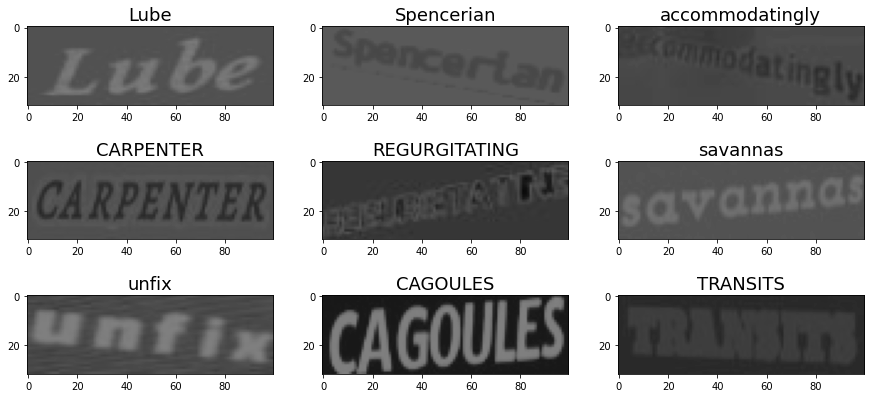

In [4]:
images = [(image.numpy() + 1) / 2 for image, _ in train_ds.take(9)]
texts = ["".join(c.decode("UTF-8") for c in label_to_char.lookup(text_labels).numpy())
         for _, text_labels in train_ds.take(9)]
    
plt.figure(figsize=(15, 7))
plot_images(images, texts, rows=3, columns=3)

In [5]:
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 1024
LABELS_PADDING_CONST = -1

def configure_for_performance(dataset, shuffle=False, seed=None):
    if shuffle:
      dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE, seed=seed)
    
    dataset = dataset.padded_batch(
        BATCH_SIZE,
        padding_values=(None, LABELS_PADDING_CONST),
        padded_shapes=(
            [datasets.IMAGE_HEIGHT, datasets.IMAGE_WIDTH, datasets.IMAGE_CHANNELS],
            [None],)
        )
    
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset

train_ds = configure_for_performance(train_ds, shuffle=True, seed=42)
val_ds = configure_for_performance(val_ds) 
test_ds = configure_for_performance(test_ds) 

In [6]:
PATCH_WIDTH = 4

NUM_ENCODERS = 3
D_MODEL = 512
D_FF = 2048
NUM_HEADS = 8

DROPOUT = 0.1

model = tf.keras.Sequential([
    vit.layers.HorizontalPatching(PATCH_WIDTH, datasets.IMAGE_HEIGHT, datasets.IMAGE_CHANNELS),
    tf.keras.layers.Dense(D_MODEL),
    vit.layers.PositionalEncoding(),
    tf.keras.layers.Dropout(DROPOUT),
    vit.layers.TransformerEncoder(NUM_ENCODERS, D_MODEL, NUM_HEADS, D_FF, dropout=DROPOUT),
    tf.keras.layers.Dense(len(datasets.CHARS) + 1, activation="softmax")
])

In [8]:
TRAIN_SIZE = 7224586
EPOCHS = 6

TOTAL_STEPS = TRAIN_SIZE * EPOCHS // BATCH_SIZE
WARMUP_FRACTION = 0.1

LEARNING_RATE = 0.003
WEIGHT_DECAY = 0

lr_schedule = vit.schedules.CosineWarmupDecay(
    LEARNING_RATE, TOTAL_STEPS, WARMUP_FRACTION)

wd_schedule = vit.schedules.CosineWarmupDecay(
    WEIGHT_DECAY, TOTAL_STEPS, WARMUP_FRACTION)

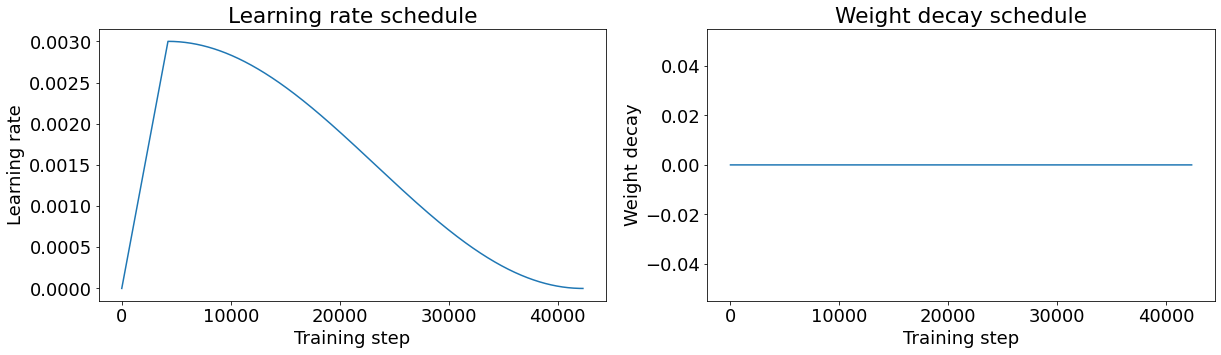

In [9]:
plt.figure(figsize=(20, 5))
plt.rcParams["font.size"] = 18

plt.subplot(121)
plt.title("Learning rate schedule")
plt.plot(lr_schedule(tf.range(TOTAL_STEPS)))
plt.ylabel("Learning rate")
plt.xlabel("Training step")

plt.subplot(122)
plt.title("Weight decay schedule")
plt.plot(wd_schedule(tf.range(TOTAL_STEPS)))
plt.ylabel("Weight decay")
_ = plt.xlabel("Training step")

In [10]:
optimizer = tfa.optimizers.AdamW(learning_rate=lr_schedule,
                                 weight_decay=wd_schedule)

In [11]:
SAVED_WEIGHTS = Path("saved_weights") / "mjsynth.h5"
SAVE_FREQUENCY = 50

SAVED_WEIGHTS.parent.mkdir(parents=True, exist_ok=True)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    SAVED_WEIGHTS, monitor="loss", save_best_only=True,
    save_weights_only=True, save_freq=SAVE_FREQUENCY)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=0)

In [12]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get("loss"))
        
loss_history = LossHistory()

In [13]:
model.compile(
    optimizer=optimizer, 
    loss=vit.losses.CTCLoss(true_labels_padding_value=LABELS_PADDING_CONST),
    metrics=[vit.metrics.CTCAccuracy(true_labels_padding_value=LABELS_PADDING_CONST)]
)

In [ ]:
model.fit(train_ds, epochs=EPOCHS, callbacks=[model_checkpoint, early_stopping, loss_history])

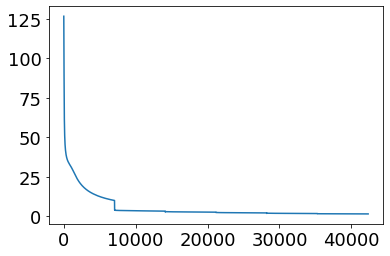

In [15]:
_ = plt.plot(loss_history.losses)

In [16]:
min(loss_history.losses)

1.5275644063949585

In [15]:
model.load_weights(SAVED_WEIGHTS)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
horizontal_patching (Horizon (None, 25, 128)           0         
_________________________________________________________________
dense (Dense)                (None, 25, 512)           66048     
_________________________________________________________________
positional_encoding (Positio (None, 25, 512)           0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 512)           0         
_________________________________________________________________
transformer_encoder (Transfo (None, 25, 512)           9457152   
_________________________________________________________________
dense_16 (Dense)             (None, 25, 63)            32319     
Total params: 9,555,519
Trainable params: 9,555,519
Non-trainable params: 0
______________________________________________

In [17]:
model.evaluate(val_ds)

784/784 [==============================] - 224s 286ms/step - loss: 1.4506 - accuracy: 0.8566


[1.450589656829834, 0.8566269278526306]

In [21]:
model.compile()
model.save("saved_model")

INFO:tensorflow:Assets written to: saved_model/assets
